## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [ ]:
%matplotlib inline

In [1]:
from fastai2.vision.all import *
from nbdev.showdoc import *

## Getting and converting the data

In [2]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [3]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [4]:
fname = '09/frame_00667_rgb.jpg'

In [5]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

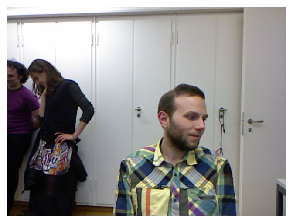

In [6]:
img = PILImage.create(path/fname)
img.show();

In [7]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [8]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c1,c2])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return TensorPoint.create(pts, img_size=img.size)

### Custom - baseline on the model

In [95]:
len(dls.train.items)

15193

In [48]:
def foo(fn):
    img = PILImage.create(dls.items[0])
    return get_ip(img, get_ctr(fn))

In [53]:
N = 1000
y_pts = [foo(e) for e in dls.items[:N]]

In [72]:
y = tensor([])
counter = 0
for _x, _y in dls.train:
    y = torch.cat((y,_y))
    counter +=1
    if counter == 10: break

In [226]:
xbar, ybar

(tensor(0.1079), tensor(0.0042))

In [92]:
xybar = tensor([[[xbar, ybar]] for _ in range(len(y))])

In [96]:
print('baseline mse:')
mse(xybar, y)

baseline mse:


tensor(0.0344)

##### end custom section ------------------

In [35]:
tmp_fn = '01/frame_00003_rgb.jpg'
img2txt_name(e) for e in 

Path('/home/user/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt')

In [28]:
np.genfromtxt(img2txt_name('01/frame_00003_rgb.jpg'))

array([[ 9.97978e-01,  2.72944e-02,  5.74071e-02],
       [-3.46956e-02,  9.90621e-01,  1.32163e-01],
       [-5.32613e-02, -1.33887e-01,  9.89564e-01],
       [ 5.19358e+01,  3.82631e+01,  8.81756e+02]])

In [31]:
img2txt_name

<function __main__.img2txt_name(f)>

In [29]:
tmp_fn = '01/frame_00003_rgb.jpg'
img2txt_name(tmp_fn)

Path('/home/user/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt')

In [26]:
fname

'09/frame_00667_rgb.jpg'

In [9]:
get_ctr(fname)

tensor([428.5814, 263.9104])

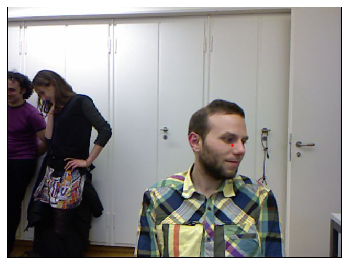

In [10]:
ctr = get_ctr(fname)
ax = img.show(figsize=(6, 6))
get_ip(img, ctr).show(ctx=ax);

## Creating a dataset

In [11]:
dblock = DataBlock(blocks=(ImageBlock, PointBlock),
                   get_items=get_image_files,
                   splitter=FuncSplitter(lambda o: o.parent.name=='13'),
                   get_y=get_ctr,
                   batch_tfms=[*aug_transforms(size=(120,160)), Normalize.from_stats(*imagenet_stats)])

In [12]:
dls = dblock.dataloaders(path, path=path, bs=64)

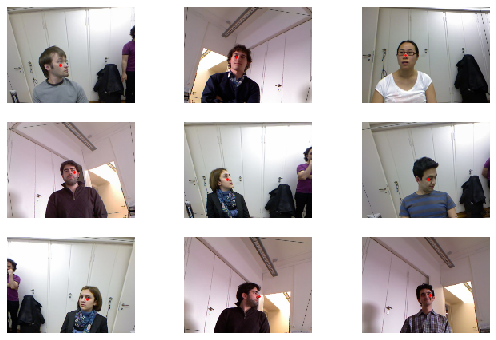

In [13]:
dls.show_batch(max_n=9, figsize=(9,6))

## Train model

In [14]:
#TODO: look in after_item for c
dls.c = dls.train.after_item.c

In [15]:
learn = cnn_learner(dls, resnet34)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=1.0964781722577754e-06)

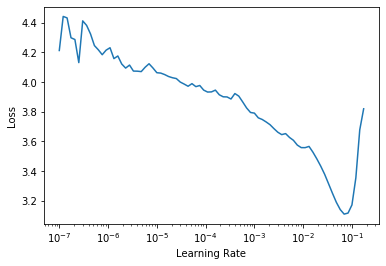

In [16]:
learn.lr_find()

In [17]:
lr = 2e-2

In [18]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.139451,0.025475,24:18
1,0.039799,0.001741,22:53
2,0.015398,0.008075,21:30
3,0.009362,0.003451,21:21
4,0.007071,0.002734,21:37


### Custom - Analysis

In [97]:
preds = learn.get_preds()

In [ ]:
yhat, yactual = preds[0], preds[1]

##### Error Comparison

In [234]:
xbar, ybar = yactual.view(-1,2).mean(dim=0)
xbar, ybar

(tensor(0.1079), tensor(0.0042))

In [235]:
mse(tensor([[xbar, ybar] for _ in range(len(yactual))]), yactual)

tensor(0.0033)

In [236]:
mse(yhat, yactual)

tensor(0.0027)

In [237]:
y = tensor([])
counter = 0
for _x, _y in dls.train:
    y = torch.cat((y,_y))
    counter +=1
    if counter == 10: break

In [292]:
df_center = pd.DataFrame(
                {'x-mean':[xbar_train.tolist(), xbar.tolist()], 
                 'y-mean':[ybar_train.tolist(), ybar.tolist()]},
                 index=['training', 'validation'])

In [283]:
mse_train_train = mse(
                    tensor([[xbar_train, ybar_train] 
                           for _ in range(len(y))])
                    , y)

mse_valid_train = mse(
                    tensor([[xbar_train, ybar_train] 
                             for _ in range(len(yactual))])
                    , yactual)

mse_valid_valid = mse(
                    tensor([[xbar, ybar] 
                           for _ in range(len(yactual))])
                    , yactual)

mse_valid_model = mse(yhat, yactual)

In [357]:
df_err = pd.DataFrame(
            {'Actual': ['Train', 'Valid', 'Valid', 'Valid'],
             'Predicted': ['mean-point: train', 'mean-point: train', 'mean-point: valid', 'model'],
             'MSE':[
                     mse_train_train.tolist(),
                     mse_valid_train.tolist(),
                     mse_valid_valid.tolist(),
                     mse_valid_model.tolist(),
             ]
            })
df_err['RMSE'] = df_err['MSE'] ** 0.5

In [358]:
print('\nDifferent Mean-Points for Training & Validation:')
display(df_center.round(3))
print('\nMSE on diff predictions types:')
display(df_err.round(4))


Different Mean-Points for Training & Validation:


,x-mean,y-mean
training,0.017,0.111
validation,0.108,0.004



MSE on diff predictions types:


,Actual,Predicted,MSE,RMSE
0,Train,mean-point: train,0.0373,0.1932
1,Valid,mean-point: train,0.0131,0.1145
2,Valid,mean-point: valid,0.0033,0.0578
3,Valid,model,0.0027,0.0523


In [251]:
xbar_train, ybar_train = y.view(-1,2).mean(dim=0)
xbar_train, ybar_train

(tensor(0.0171), tensor(0.1105))

##### Build Figures for Model results on Validation

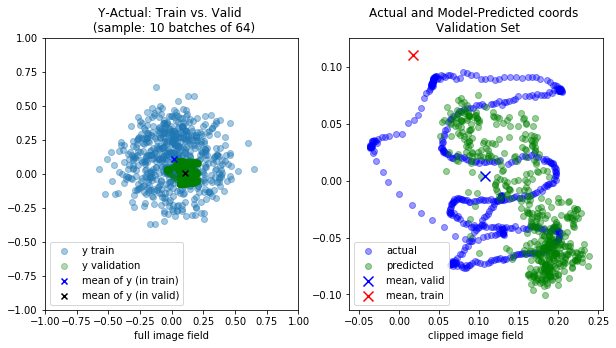

In [360]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].scatter(y.view(-1,2)[:,0], y.view(-1,2)[:,1], alpha=0.4)
ax[0].set_ylim(-1,1)
ax[0].set_xlim(-1,1);

ax[0].scatter(yactual.view(-1,2)[:,0], yactual.view(-1,2)[:,1], 
            alpha=0.3, color='green')
ax[0].scatter(xbar_train, ybar_train, c='blue', marker='x');
ax[0].scatter(xbar, ybar, c='black', marker='x');

ax[0].legend(['y train', 'y validation', 
            'mean of y (in train)', 'mean of y (in valid)'])
ax[0].set_title('Y-Actual: Train vs. Valid \n (sample: 10 batches of 64)');
ax[0].set_xlabel('full image field')

ax[1].scatter(yactual.view(-1,2)[:,0], yactual.view(-1,2)[:,1], c='b', alpha=0.4)
ax[1].scatter(yhat.view(-1,2)[:,0], yhat.view(-1,2)[:,1], c='g', alpha=0.4)
ax[1].scatter(xbar, ybar, c='blue', marker='x', s=100)
ax[1].scatter(xbar_train, ybar_train, c='red', marker='x', s=100)
ax[1].legend(['actual', 'predicted', 'mean, valid', 'mean, train'])
ax[1].set_title('Actual and Model-Predicted coords \n Validation Set');
ax[1].set_xlabel('clipped image field');

In [184]:
pad = 1.1
min_val = yactual.view(-1,2).min(dim=0).values.min() * pad
max_val = yactual.view(-1,2).max(dim=0).values.max() * pad
ll = np.linspace(min_val, max_val);
min_val, max_val

(tensor(-0.0845), tensor(0.2246))

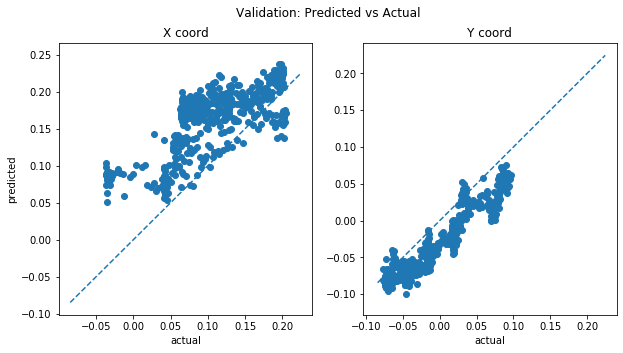

In [322]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].scatter(yactual[:,0,0],  yhat[:,0] )
ax[0].plot(ll, ll, linestyle='--' )
ax[0].set_title('X coord')
ax[0].set_xlabel('actual')
ax[0].set_ylabel('predicted')
ax[1].scatter(yactual[:,0,1],  yhat[:,1] )
ax[1].plot(ll, ll, linestyle='--' )
ax[1].set_title('Y coord')
ax[1].set_xlabel('actual')
fig.suptitle('Validation: Predicted vs Actual');

In [179]:
mean_resids  = tensor([xbar, ybar]) - yactual
model_resids = yhat - yactual.view(-1,2)

In [323]:
dist_mean_resid = ((mean_resids.view(-1,2)**2)
                    .sum(dim=1)**0.5)
dist_model_resid = ((model_resids.view(-1,2)**2)
                       .sum(dim=1)**0.5)

avg_dist_mean_resid  = dist_mean_resid.mean()
avg_dist_model_resid = dist_model_resid.mean()

avg_dist_mean_resid, avg_dist_model_resid

(tensor(0.0751), tensor(0.0686))

In [188]:
pad = 1.1
min_val = mean_resids.view(-1,2).min(dim=0).values.min() * pad
max_val = mean_resids.view(-1,2).max(dim=0).values.max() * pad
min_val, max_val

(tensor(-0.1060), tensor(0.1586))

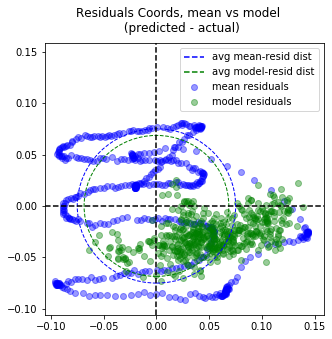

In [368]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter(mean_resids.view(-1,2)[:,0], 
            mean_resids.view(-1,2)[:,1],
            c='blue', alpha=0.4)

ax.scatter(model_resids.view(-1,2)[:,0], 
            model_resids.view(-1,2)[:,1],
            c='green', alpha=0.4)

circle_mean =  plt.Circle((0,0), avg_dist_mean_resid, 
                        fill=False, linestyle='--', color='b')
circle_model = plt.Circle((0,0), avg_dist_model_resid, 
                        fill=False, linestyle='--', color='g')

ax.add_artist(circle_mean)
ax.add_artist(circle_model)

ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val);

ax.plot([1e-5, 1e-6], [1e-5, 1e-6], c='blue', linestyle='--')
ax.plot([1e-5, 1e-6], [1e-5, 1e-6], c='green', linestyle='--')

ax.legend([
            'avg mean-resid dist', 'avg model-resid dist',
            'mean residuals', 'model residuals', ])

ax.hlines(0,min_val, max_val, linestyle='--')
ax.vlines(0,min_val, max_val, linestyle='--')

plt.suptitle('Residuals Coords, mean vs model \n (predicted - actual)');

In [332]:
len(dist_mean_resid)

485

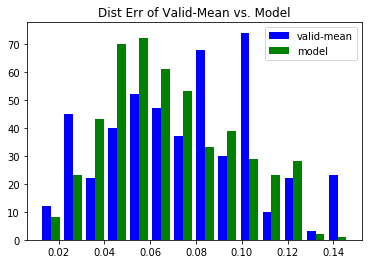

In [343]:
plt.hist([ dist_mean_resid.tolist(), 
           dist_model_resid.tolist()
         ], color=['blue','green'], bins=14,
        );
plt.legend(['valid-mean', 'model']);
plt.title('Dist Err of Valid-Mean vs. Model');
#          color='blue', bins=20);
# plt.hist(dist_model_resid, color='green', bins=20);

In [ ]:
# TODO
add histogram of errors
add the training + validation mean to coords graph
writeup: the model mostly works to locate where the head is, 
    not where the center point
verdict

#### end custom -------------------------------------------------------------

In [147]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

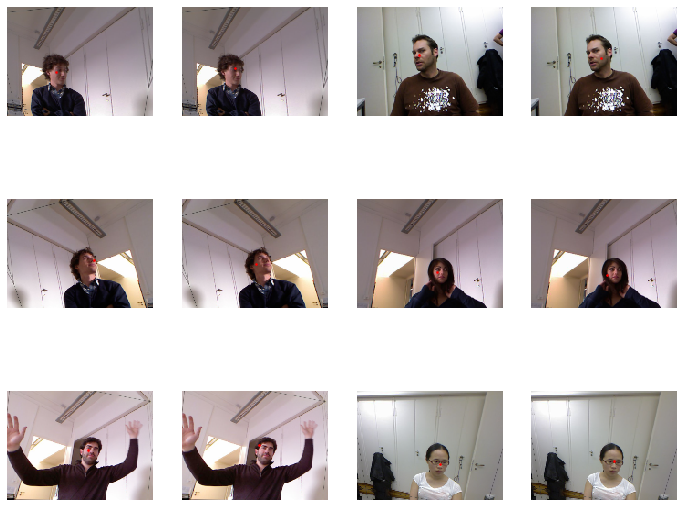

In [ ]:
learn.show_results(max_n=6)

## Data augmentation

In [ ]:
def repeat_one_file(path): 
    items = get_image_files(path)
    return [items[0]] * 500

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, PointBlock),
                   get_items=repeat_one_file,
                   splitter=RandomSplitter(),
                   get_y=get_ctr)

In [ ]:
tfms = aug_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1., size=(120,160))

In [ ]:
dls = dblock.dataloaders(path, path=path, bs=64, batch_tfms=[*tfms, Normalize.from_stats(*imagenet_stats)])

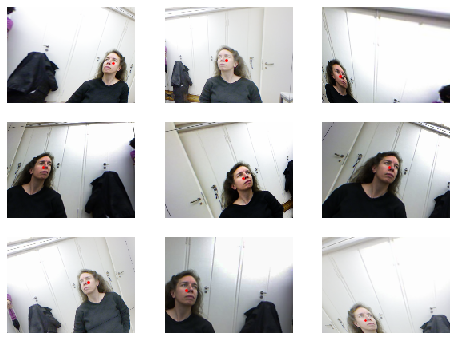

In [ ]:
dls.show_batch(max_n=9, figsize=(8,6))